# Part2: Seq2Seq Machine Translation with Attention (Total: 50 Points)
## Objectives:
Implement a sequence-to-sequence model with attention to perform machine translation between two languages (e.g., English to French). This task will help you understand how con- ditioned generation works in the context of translating sequences from one domain to another, leveraging the power of LSTMs and attention mechanisms.

- Student Name: Lyle He

## Final Training 

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/language-translation-englishfrench/eng_-french.csv
/kaggle/input/nmt-model-1/nmt_model_1.pth


## Utility Functions

In [2]:
import re
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import pyplot as plt

def clean_text(text):
    text = text.replace('\xa0', ' ')  # Replace non-breaking space with regular space
    text = text.replace('\u202f', ' ')  # Replace narrow non-breaking space with regular space
    text = re.sub('[\xad\u200b]', '', text)  # Remove soft hyphens and zero-width spaces
    text = unidecode(text)  # Remove accents
    text = text.lower()  # Convert to lowercase
    return text

def tokenize_and_add_special_tokens(text):
    tokens = word_tokenize(text)
    tokens = ['<SOS>'] + tokens + ['<EOS>']
    return tokens

def build_vocab_bidirectional(tokenized_texts):
    token_counts = Counter(token for text in tokenized_texts for token in text)

    # We start indexing from 2 to leave 0 and 1 for '<PAD>' and '<UNK>' tokens.
    vocab = {token: idx + 2 for idx, (token, count) in enumerate(token_counts.items())}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    # Inverse vocabulary
    inv_vocab = {idx: token for token, idx in vocab.items()}
    return vocab, inv_vocab

def tokens_to_sequence(tokens, vocab, maxlen=120, padding=True):
    if padding and len(tokens) <= maxlen:
        return [vocab.get(token, vocab['<UNK>']) for token in tokens] + [vocab['<PAD>']]*(maxlen-len(tokens))
    elif not padding:
        return [vocab.get(token, vocab['<UNK>']) for token in tokens]
    else:
        raise ValueError('Some lenght of tokens larger than the maxlen')
    

# plot the training and validation loss, losses_all_epoch = {'train': [], 'val': []}
    
def plot_training_validation_loss(losses_all_epoch):
    plt.plot(losses_all_epoch['train'], label='train')
    plt.plot(losses_all_epoch['val'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Data Preprocessing

In [3]:
# data preprocessing for the machine translation task
import numpy as np
import pandas as pd
import nltk

nltk.download('punkt')

filepaths = '/kaggle/input/language-translation-englishfrench/eng_-french.csv'

df = pd.read_csv(filepaths)
df.columns = ['en', 'fr']

print("number of samples", df.shape[0])
print("characters in English sentences\n", set("".join(df['en'].to_list())))
print("characters in French sentences\n", set("".join(df['fr'].to_list())))

print("length of Engish characters in English sentences", len(set("".join(df['en'].to_list()))))
print("length of French characters in French sentences", len(set("".join(df['fr'].to_list()))))

cleaned_df = df.map(clean_text)
print("Remove the unmeaningful character and convert to uppercase, and keep any meaningful characters")
print("length of en character set after cleaning", len(set("".join(cleaned_df['en']))))
print("length of fr character set after cleaning", len(set("".join(cleaned_df['fr']))))

# Apply tokenization to each sentence
print("Tokenize the sentences")
cleaned_df['en_tokens'] = cleaned_df['en'].apply(tokenize_and_add_special_tokens)
cleaned_df['fr_tokens'] = cleaned_df['fr'].apply(tokenize_and_add_special_tokens)

print("English-French pairs Examples")
for index, (en, fr) in enumerate(zip(cleaned_df['en'], cleaned_df['fr'])):
    if index > 5:
        break
    print(f'Src: {en}\tTgt: {fr}')

# Build the vocabulary
print("Build the vocabulary")
en_vocab, en_inv_vocab = build_vocab_bidirectional(cleaned_df['en_tokens'])
fr_vocab, fr_inv_vocab = build_vocab_bidirectional(cleaned_df['fr_tokens'])

# check the vocabulary content
print("English vocabulary Examples")
for index, (key, value) in enumerate(en_vocab.items()):
    if index > 20:
        break
    print(f'{key}\t: {value}')
print("French vocabulary Examples")
for index, (key, value) in enumerate(fr_vocab.items()):
    if index > 20:
        break
    print(f'{key}\t: {value}')

# Convert tokens to sequences
print("Convert tokens to sequences")
en_sequence = cleaned_df['en_tokens'].apply(tokens_to_sequence, args=(en_vocab, max(cleaned_df['en_tokens'].map(lambda x:len(x)).to_list()))).to_list()
fr_sequence = cleaned_df['fr_tokens'].apply(tokens_to_sequence, args=(fr_vocab, max(cleaned_df['fr_tokens'].map(lambda x:len(x)).to_list()))).to_list()

# check the sequence content
print("English sequence Examples")
for index, sequence in enumerate(en_sequence):
    if index > 5:
        break
    sentence = [en_inv_vocab.get(idx, "<UNK>") for idx in sequence if idx != en_vocab['<PAD>']]
    print(f'{sentence}')
    
print("French sequence Examples")
for index, sequence in enumerate(fr_sequence):
    if index > 5:
        break
    sentence = [fr_inv_vocab.get(idx, "<UNK>") for idx in sequence if idx != fr_vocab['<PAD>']]
    print(f'{sentence}')

# Summary of the data preprocessing
print("Summary of the data preprocessing")
print("length of en_vocab,", len(en_vocab))
print("length of fr_vocab,", len(fr_vocab))
print("number of samples - en_sequence: ", len(en_sequence))
print("number of samples - fr_sequence: ", len(fr_sequence))

print("data preprocessing done")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
number of samples 175621
characters in English sentences
 {'N', '"', 'e', '0', 'p', 'b', '%', 'P', 'é', '—', 'а', '-', 'r', 'T', '7', 'M', '2', 'y', 'W', 'Z', 'c', 'ç', 's', 'h', '8', 'O', 'd', 'Q', 'k', 't', 'ö', ',', 'L', 'C', '4', '&', '\xa0', 'a', '€', 'D', 'I', 'u', 'Y', 'U', 'l', 'z', 'x', 'v', '’', 'n', '.', 'K', 'E', 'ú', 'R', 'F', '1', '/', ' ', 'j', 'i', '!', '6', '?', 'G', 'g', "'", 'B', '5', 'f', '–', 'w', '+', 'V', 'X', 'A', '3', 'º', 'o', 'm', ':', 'q', 'S', '₂', '$', ';', 'H', '‘', '\xad', 'J', '9'}
characters in French sentences
 {'è', 'N', '"', 'e', 'À', '0', 'p', 'b', '%', 'P', 'é', '-', 'r', 'T', '7', 'M', '2', 'y', 'W', 'Z', 'c', 'ç', 'ê', 's', 'h', '8', 'd', 'O', 'Q', 'k', 't', 'ö', '\u202f', ',', 'L', 'C', 'É', '4', '&', '\xa0', 'a', 'D', 'ô', 'I', 'î', 'u', 'U', 'Y', 'l', 'z', '«', 'x', 'v', '’', 'n', 'С', '…', '.', 'ù', 'Ê', ')', 'K', 'E', '\u2009'

## Seq2Seq Encoder-Decoder With Attention Model Definition


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# create the dataset
class NMTDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]

class WordEmbeddingForTranlationTask(nn.Module): 
    """
    WordEmbeddingForTranlationTask: A simple word embedding model for the translation task.
    """
    def __init__(self, vocab_src, vocab_tgt, embed_size):
        """
        @param vocab_src (dict): Vocabulary for the source language
        @param vocab_tgt (dict): Vocabulary for the target language
        @param embed_size (int): Embedding size (dimensionality)
        """
        super(WordEmbeddingForTranlationTask, self).__init__()
        self.embed_size = embed_size

        src_pad_token_index = vocab_src['<PAD>']
        tgt_pad_token_index = vocab_tgt['<PAD>']

        self.source = nn.Embedding(len(vocab_src), embed_size, src_pad_token_index)
        self.target = nn.Embedding(len(vocab_tgt), embed_size, tgt_pad_token_index)

class NMTModel(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, vocab_src, vocab_tgt, embedding_dim, hidden_dim, dropout_rate=0.2, has_attention=True):
        """
        @param vocab_src : Vocabulary object containing src language, shape: (batch_size, src_sequence_length)
        @param vocab_tgt : Vocabulary object containing tgt language, shape: (batch_size, tgt_sequence_length)
        @param embedding_dim (int): Embedding size (dimensionality)
        @param hidden_dim (int): Hidden size (dimensionality)
        @param dropout_rate (float): Dropout rate
        """
        super(NMTModel, self).__init__()

        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt

        # model hyperparameters
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.has_attention = has_attention

        # nerual network layers
        self.embeddings = WordEmbeddingForTranlationTask(vocab_src, vocab_tgt, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.decoder = nn.LSTMCell(embedding_dim+hidden_dim,hidden_dim)

        # projection layers
        self.encoder_hidden_to_initial_decoder_hidden = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
        self.encoder_cell_to_initial_decoder_cell = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
        self.encoder_hidden_to_decoder_hidden_for_attention = nn.Linear(hidden_dim*2, hidden_dim, bias=False)

        if self.has_attention:
            self.combined_output_and_hidden_to_hidden = nn.Linear(hidden_dim*3, hidden_dim, bias=False)
        else:
            self.combined_output_and_hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        self.target_vocab_projection = nn.Linear(hidden_dim, len(vocab_tgt), bias=False)
        self.dropout = nn.Dropout(dropout_rate)        
    
    def forward(self, input_sequences, target_sequences):
        """
        @param input_sequence (torch.Tensor): input sequence of word indices, shape: (batch_size, src_sequence_length)
        @param target_sequence (torch.Tensor): target sequence of word indices, shape: (batch_size, tgt_sequence_length)
        """

        # transpose the input sequence and target sequence
        input_sequences = torch.t(input_sequences) # shape: (src_sequence_length, batch_size)
        target_sequences = torch.t(target_sequences) # shape: (tgt_sequence_length, batch_size)
        
        # encoder computation
        encoder_hiddens, (last_hidden, last_cell) = self.encode(input_sequences)

        # last hidden and cell projection
        initial_decoder_hidden = self.encoder_hidden_to_initial_decoder_hidden(last_hidden)
        initial_decoder_cell = self.encoder_cell_to_initial_decoder_cell(last_cell)

        # decoder computation
        combined_outputs = self.decode(target_sequences, encoder_hiddens, initial_decoder_hidden, initial_decoder_cell)
        
        # project the combined outputs to the target vocabulary
        combined_outputs = self.dropout(combined_outputs)
        combined_outputs = self.target_vocab_projection(combined_outputs)
        P = F.log_softmax(combined_outputs, dim=-1)

        # target mask
        target_mask = (target_sequences != self.vocab_tgt['<PAD>']).float()

        # Compute log probability of generating true target words
        target_sequences = target_sequences[1:]
        target_mask = target_mask[1:]

        target_gold_words_log_prob = torch.gather(P, dim=-1, index=target_sequences.unsqueeze(-1)).squeeze(-1) #* target_mask
        scores = target_gold_words_log_prob.sum(dim=0)

        return scores

    def encode(self, input_sequence):
        """
        @param input_sequence (torch.Tensor): input sequence of word indices, shape: (src_sequence_length, batch_size)
        @return encoder_hiddens (torch.Tensor): output of the encoder (the excat hidden states of each time step)
        @return last_hidden (torch.Tensor): last hidden state of the encoder
        @return last_cell (torch.Tensor): last cell state of the encoder
        """
        # word embedding
        embeddings = self.embeddings.source(input_sequence) # shape: (src_sequence_length, batch_size, embedding_dim)

        # encoder computation
        encoder_hiddens, (last_hidden, last_cell) = self.encoder(embeddings)

        encoder_hiddens = torch.permute(encoder_hiddens,(1, 0, 2)) # shape: (batch_size, src_sequence_length, hidden_dim*2)

        # since the encoder is bidirectional, we need to concatenate the forward and backward hidden states
        last_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1) # dim=1 to concatenate along the column
        last_cell = torch.cat((last_cell[0], last_cell[1]), dim=1)

        return encoder_hiddens, (last_hidden, last_cell)

    def decode(self, target_sequence, encoder_hiddens, initial_decoder_hidden, initial_decoder_cell):
        """
        @param target_sequence (torch.Tensor): target sequence of word indices, shape: (tgt_sequence_length, batch_size)
        @param encoder_hiddens (torch.Tensor): output of the encoder (the excat hidden states of each time step)
        @param initial_decoder_hidden (torch.Tensor): initial hidden state of the decoder
        @param initial_decoder_cell (torch.Tensor): initial cell state of the decoder
        """
        
        # Initialize a previous Output
        batch_size = encoder_hiddens.size(0)
        prev_output = torch.zeros(batch_size, self.hidden_dim, device=self.device)

        # decoder hidden and cell states
        decoder_hidden_t = initial_decoder_hidden
        decoder_cell_t = initial_decoder_cell
        
        # word embedding
        embeddings = self.embeddings.target(target_sequence) # shape: (tgt_sequence_length, batch_size, embedding_dim)

        # encoder hidden states for attention computation
        encoder_hiddens_for_attention = self.encoder_hidden_to_decoder_hidden_for_attention(encoder_hiddens)
        
        # decoder computation
        combined_outputs = []

        for word_embedding_at_t in torch.split(embeddings, 1, dim=0):
            # shape of word_at_t: (1, batch_size, embedding_dim)
            word_embedding_at_t = word_embedding_at_t.squeeze(0) # remove the dimension of 0
            # shape of word_at_t: (batch_size, embedding_dim)

            word_embedding_cat_prev_output_at_t = torch.cat((word_embedding_at_t, prev_output), dim=1)

            # lstm cell computation and attention computation
            combined_output_t,  dec_state, _ = self.step(word_embedding_cat_prev_output_at_t, encoder_hiddens, encoder_hiddens_for_attention, decoder_hidden_t, decoder_cell_t)
            decoder_hidden_t, decoder_cell_t = dec_state
            combined_outputs.append(combined_output_t)
            prev_output = combined_output_t
        combined_outputs = torch.stack(combined_outputs) 

        return combined_outputs
    
    def step(self, features_t, encoder_hiddens, encoder_hiddens_for_attention, prev_hidden, prev_cell):
        """
        1. input the features into LSTM cell and get the hidden state and cell state
        2. compute the attention score
        3. compute the context vector
        4. compute the combined output

        @param features_t (torch.Tensor): input features, shape: (batch_size, feature_dim)
        @param encoder_hiddens (torch.Tensor): output of the encoder (the excat hidden states of each time step), shape: (batch_size, src_sequence_length, hidden_dim)
        @param encoder_hiddens_for_attention, shape: (batch_size, src_sequence_length, hidden_dim)
        @param prev_hidden (torch.Tensor): previous hidden state of the decoder
        @param prev_cell (torch.Tensor): previous cell state of the decoder
        """
        decoder_hidden_t, decoder_cell_t = self.decoder(features_t, (prev_hidden, prev_cell)) # shape of decoder_hidden_t: (batch_size, hidden_dim)

        if self.has_attention:
            # compute the attention score, use encoder_hidden_t to dot product with encoder_hiddens_for_attention
            attention_score = torch.bmm(decoder_hidden_t.unsqueeze(1), encoder_hiddens_for_attention.permute(0, 2, 1)).squeeze(1) # shape: (batch_size, src_sequence_length)
            attention_score_after_softmax = torch.softmax(attention_score, dim=1)

            # (batch_size, 1, src_sequence_length) * (batch_size, src_sequence_length, hidden_dim*2) -> (batch_size, 1, hidden_dim*2)
            src_context_vector = torch.bmm(attention_score_after_softmax.unsqueeze(1), encoder_hiddens).squeeze(1)
        

            # concatenate the output of the decoder and the context vector
            combined_output = torch.cat((decoder_hidden_t, src_context_vector), dim=1)

            # project the combined output to the hidden_dim
            final_features = self.combined_output_and_hidden_to_hidden(combined_output)

            return final_features, (decoder_hidden_t, decoder_cell_t), attention_score_after_softmax

        else:
            combined_output = decoder_hidden_t
            # project the combined output to the hidden_dim
            final_features = self.combined_output_and_hidden_to_hidden(combined_output)
            return final_features, (decoder_hidden_t, decoder_cell_t), 0

    def test(self, input_sequence, end_token_index, max_length=50, is_just_one_sentence=False):
        """
        @param input_sequence (torch.Tensor): input sequence of word indices, shape: (src_sequence_length, batch_size)
        @param max_length (int): maximum length of the target sequence
        @return decoded_words (list): list of words in the target language
        """
        input_sequence = torch.t(input_sequence) # shape: (src_sequence_length, batch_size)
        batch_size = input_sequence.size(1)
        encoder_hiddens, (last_hidden, last_cell) = self.encode(input_sequence)
        prev_output = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        decoder_hidden_t = self.encoder_hidden_to_initial_decoder_hidden(last_hidden)
        decoder_cell_t = self.encoder_cell_to_initial_decoder_cell(last_cell)
        encoder_hiddens_for_attention = self.encoder_hidden_to_decoder_hidden_for_attention(encoder_hiddens)    
        
        decoded_words = []
        # torch.tensor([self.vocab_tgt['<SOS>']]
        first_word_index = torch.tensor([self.vocab_tgt['<SOS>']] * batch_size, device=self.device).unsqueeze(0)
        word_embedding_at_t = self.embeddings.target(first_word_index).squeeze(0) # shape: (batch_size, embedding_dim)

        attention_record = []
        for _ in range(max_length):
            word_embedding_cat_prev_output_at_t = torch.cat((word_embedding_at_t, prev_output), dim=1)
            combined_output_t, (decoder_hidden_t, decoder_cell_t), attention_score_after_softmax = self.step(word_embedding_cat_prev_output_at_t, encoder_hiddens, encoder_hiddens_for_attention, decoder_hidden_t, decoder_cell_t)
            combined_output_t = self.dropout(combined_output_t)
            prev_output = combined_output_t

            combined_output_t = self.target_vocab_projection(combined_output_t)
            P = F.log_softmax(combined_output_t, dim=-1)
            word_index = torch.argmax(P, dim=-1)

            if is_just_one_sentence and word_index.item() == end_token_index:
                break
            
            word_embedding_at_t = self.embeddings.target(word_index)
            
            # word_index is a tensor, shape: ([batch_size])
            decoded_words.append(word_index)
            
            if self.has_attention:
                attention_record.append(attention_score_after_softmax)
        
        if self.has_attention:
            attention_record = torch.stack(attention_record)
        decoded_words = torch.stack(decoded_words) 
        return decoded_words, attention_record
    
    @property
    def device(self):
        """
        @return device (torch.device): device on which the model is located
        """
        return self.embeddings.source.weight.device
    


## Train and Test Function

In [5]:
# train function display the training process for each epoch
def train_NMTModel(model, train_loader, optimizer, device, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        trained_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        for i, (src, tgt) in enumerate(progress_bar):
            src = src.to(device)
            tgt = tgt.to(device)
            optimizer.zero_grad()
            batch_size = src.shape[0]

            example_losses = -model(src, tgt)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size

            loss.backward()
            optimizer.step()

            trained_samples += batch_size
            total_loss += batch_loss.item()
            progress_bar.set_postfix({'loss': total_loss / trained_samples})
        if trained_samples > 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / trained_samples}')
        else:
            print(f'Epoch {epoch+1}, Total Loss: {total_loss}')

# train and validation function
def train_val_NMTModel(model, train_loader, val_loader, optimizer, device, epochs):
    """
    stored the loss for each epoch for plotting
    """
    losses_all_epoch = {'train': [], 'val': []}
    model.to(device)
    model.train()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        trained_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        for src, tgt in progress_bar:
            src = src.to(device)
            tgt = tgt.to(device)
            optimizer.zero_grad()
            batch_size = src.shape[0]

            example_losses = -model(src, tgt)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size

            loss.backward()
            optimizer.step()

            trained_samples += batch_size
            total_loss += batch_loss.item()
            progress_bar.set_postfix({'Average Loss': total_loss / trained_samples})
        losses_all_epoch['train'].append(total_loss / trained_samples)
        if trained_samples > 0:
            print(f'Epoch {epoch+1}, Average Train Loss: {total_loss / trained_samples}', end=', ')
        else:
            print(f'Epoch {epoch+1}, Total Train Loss: {total_loss}', end=',')
        
        # validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            val_samples = 0
            for src, tgt in val_loader:
                src = src.to(device)
                tgt = tgt.to(device)
                batch_size = src.shape[0]
                example_losses = -model(src, tgt)
                batch_loss = example_losses.sum()
                val_samples += batch_size
                total_val_loss += batch_loss.item()
            if val_samples > 0:
                losses_all_epoch['val'].append(total_val_loss / val_samples)
                print(f'Epoch {epoch+1}, Average Val Loss: {total_val_loss / val_samples}')
            else:
                print(f'Epoch {epoch+1}, Total Val Loss: {total_val_loss}')
        model.train()
    return losses_all_epoch

# define a function to test the model with a sentence
def test_model(model, sentence, fr_inv_vocab, device, max_length=50):
    model.eval()
    if len(sentence.split()) > max_length:
        raise ValueError('The length of the sentence is larger than the max_length')
    with torch.no_grad():
        # tokenize the sentence
        en_vocab = model.vocab_src
        fr_vocab = model.vocab_tgt
        sequence = tokens_to_sequence(tokenize_and_add_special_tokens(clean_text(sentence)), en_vocab, padding=False)
        # convert the sequence to tensor
        src = torch.tensor(sequence, dtype=torch.long).to(device)
        # add the batch dimension
        src = src.unsqueeze(0)
        # get the predictions
        decoded_words, attention = model.test(src, end_token_index=fr_vocab['<EOS>'], is_just_one_sentence=True)
        # convert the tensor to a list
        decoded_words = decoded_words.squeeze(1).tolist()
        predict_sentence = [fr_inv_vocab.get(idx, '<UNK>') for idx in decoded_words]
        return " ".join(predict_sentence), attention

def test_model_bleu(model, test_loader, device):
    model.eval()
    fr_vocab = model.vocab_tgt
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    with torch.no_grad():
        scores = 0
        for i, (src, tgt) in enumerate(test_loader):
            src = src.to(device)
            tgt = tgt.to(device)
            batch_size = src.shape[0]
            predicted_target_indices, attention_record = model.test(src, end_token_index=fr_vocab['<EOS>'])
            # transpose the predicted_target_indices to (batch_size, max_length)
            predicted_target_indices = predicted_target_indices.transpose(0, 1)
            # convert tensor to list
            predicted_target_indices = predicted_target_indices.tolist()
            tgt_indices = tgt.tolist()
            # get the <EOS> token index
            eos_index = fr_vocab['<EOS>']
            # remove the <EOS> token and the tokens after it of the predicted_target_indices
            for row in range(batch_size):
                if eos_index in predicted_target_indices[row]:
                    first_predicted_eos_index = predicted_target_indices[row].index(eos_index)
                    predicted_target_indices[row] = predicted_target_indices[row][:first_predicted_eos_index]
                if eos_index in tgt_indices[row]:
                    first_tgt_eos_index = tgt_indices[row].index(eos_index)
                    tgt_indices[row] = [tgt_indices[row][:first_tgt_eos_index]]
            chencherry = SmoothingFunction()
            # calculate the bleu score
            bleu_scores = [sentence_bleu(refs, pred,smoothing_function=chencherry.method1) for refs, pred in zip(tgt_indices, predicted_target_indices)]
            scores += sum(bleu_scores)/len(bleu_scores)
        return scores / len(test_loader)

## Load Data and Prepare for Training

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from data_preprocessing import en_sequence, fr_sequence, en_vocab, fr_vocab, en_inv_vocab, fr_inv_vocab
# from model import NMTModel, NMTDataset

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [8]:
# create the dataset
src_data_tensor = torch.tensor(en_sequence, dtype=torch.long).to(device)
tgt_data_tensor = torch.tensor(fr_sequence, dtype=torch.long).to(device)

# split the data, since the data is to much we get 20% for training, and 2% for testing
temp_src_tensor, _, temp_tgt_tensor, _ = train_test_split(src_data_tensor, tgt_data_tensor, test_size=0.5, random_state=42)
train_src_tensor, temp_src_tensor, train_tgt_tensor, temp_tgt_tensor = train_test_split(temp_src_tensor, temp_tgt_tensor, test_size=0.2, random_state=42)

## Start Training 
The Hyper-parameters ara choose according to the another gride search process, see it in `neuralmachinetranslation_hyperparameter_grid_search.ipynb`

In [9]:
embedding_dim = 512
hidden_dim = 512
dropout = 0.5
batch_size = 128
epochs = 15

# split the temp data to validation and test data
val_src_tensor, test_src_tensor, val_tgt_tensor, test_tgt_tensor = train_test_split(temp_src_tensor, temp_tgt_tensor, test_size=0.5, random_state=42)

print("src train data sample number: ", len(train_src_tensor))
print("tgt train data sample number: ", len(train_tgt_tensor))
print("src val data sample number: ", len(val_src_tensor))
print("tgt val data sample number: ", len(val_tgt_tensor))
print("src test data sample number: ", len(test_src_tensor))
print("tgt test data sample number: ", len(test_tgt_tensor))


# create the train, validation and test dataset
train_dataset = NMTDataset(train_src_tensor, train_tgt_tensor)
val_dataset = NMTDataset(val_src_tensor, val_tgt_tensor)
test_dataset = NMTDataset(test_src_tensor, test_tgt_tensor)

# create the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

src train data sample number:  70248
tgt train data sample number:  70248
src val data sample number:  8781
tgt val data sample number:  8781
src test data sample number:  8781
tgt test data sample number:  8781


### 1. Seq2Seq Encoder-Decoder with Attention Model

NMTModel(
  (embeddings): WordEmbeddingForTranlationTask(
    (source): Embedding(14516, 512, padding_idx=0)
    (target): Embedding(28336, 512, padding_idx=0)
  )
  (encoder): LSTM(512, 512, bidirectional=True)
  (decoder): LSTMCell(1024, 512)
  (encoder_hidden_to_initial_decoder_hidden): Linear(in_features=1024, out_features=512, bias=False)
  (encoder_cell_to_initial_decoder_cell): Linear(in_features=1024, out_features=512, bias=False)
  (encoder_hidden_to_decoder_hidden_for_attention): Linear(in_features=1024, out_features=512, bias=False)
  (combined_output_and_hidden_to_hidden): Linear(in_features=1536, out_features=512, bias=False)
  (target_vocab_projection): Linear(in_features=512, out_features=28336, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch 1, Average Train Loss: 40.62434399892279, Epoch 1, Average Val Loss: 25.40223620690269


Epoch 2, Average Train Loss: 21.664856228113255, Epoch 2, Average Val Loss: 18.580827548582345


Epoch 3, Average Train Loss: 19.307707895709665, Epoch 3, Average Val Loss: 17.662519529025737


Epoch 4, Average Train Loss: 14.670819429259218, Epoch 4, Average Val Loss: 15.346176044936334


Epoch 5, Average Train Loss: 12.036505953405701, Epoch 5, Average Val Loss: 14.68578274414841


Epoch 6, Average Train Loss: 10.463651542633164, Epoch 6, Average Val Loss: 14.292445436613853


Epoch 7, Average Train Loss: 9.280564087803768, Epoch 7, Average Val Loss: 14.148296328832316


Epoch 8, Average Train Loss: 8.563304216032785, Epoch 8, Average Val Loss: 14.503201200456775


Epoch 9, Average Train Loss: 8.10081572815574, Epoch 9, Average Val Loss: 14.561184084533545


Epoch 10, Average Train Loss: 7.842928449489332, Epoch 10, Average Val Loss: 14.636866149103


Epoch 11, Average Train Loss: 7.6322479039522255, Epoch 11, Average Val Loss: 14.981495886671151


Epoch 12, Average Train Loss: 7.649635728515236, Epoch 12, Average Val Loss: 14.955337668643592


Epoch 13, Average Train Loss: 7.056129507697562, Epoch 13, Average Val Loss: 15.269482747173408


Epoch 14, Average Train Loss: 7.386363603900144, Epoch 14, Average Val Loss: 15.225160839209835


Epoch 15, Average Train Loss: 6.88469412190783, Epoch 15, Average Val Loss: 15.735481320420154


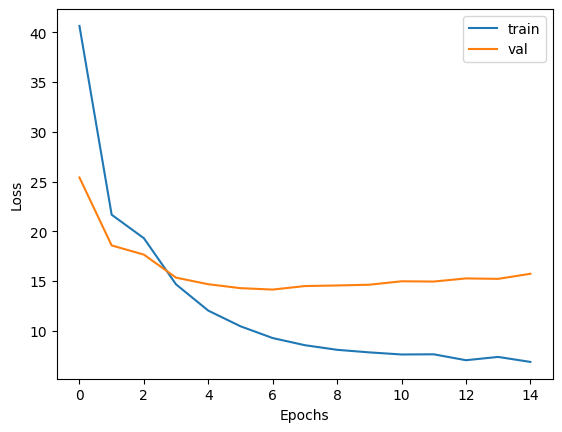

In [10]:
# create the model
model = NMTModel(en_vocab, fr_vocab, embedding_dim, hidden_dim, dropout)
model.to(device)
model.train()

# check the model
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# train and validation
losses_all_epoch = train_val_NMTModel(model, train_loader, val_loader, optimizer, device, epochs)
plot_training_validation_loss(losses_all_epoch)

In [11]:
# save the model
model_path = "nmt_model_with_attention.pth"
torch.save(model.state_dict(), model_path)
# model_path = '/kaggle/input/nmt-model-1/nmt_model_1.pth'
# model.load_state_dict(torch.load(model_path))

In [12]:
# test the model with the test_loader
score = test_model_bleu(model, test_loader, device)
print(f'bleu score with_attention: {score}')

bleu score with_attention: 0.29051475423542067


Src: What is your name ?
Tgt: comment vous nom ?

Src: I am doing great
Tgt: je suis bon en train de faire .

Src: What are you doing today ?
Tgt: que faites-vous aujourd'hui ?

Src: Can you help me with my homework ?
Tgt: pouvez-vous m'aider a mes devoirs ?

Src: I am a student at the university and I am studying computer science
Tgt: je suis etudiant a l'universite et j'ai etudier le ordinateur .

Src: In my opinion , the best way to learn a new language is to practice speaking with native speakers
Tgt: selon mon avis , le meilleur moyen est de pratiquer avec ce qui est a parler de parler un truc de monde a apprendre le pays de parler avec ce qui est a parler de parler .

Src: I usually wake up at 6 am and then I go for a run in the park before I start working
Tgt: je me leve habituellement au restaurant et puis je commence a travailler dans le parc avant .



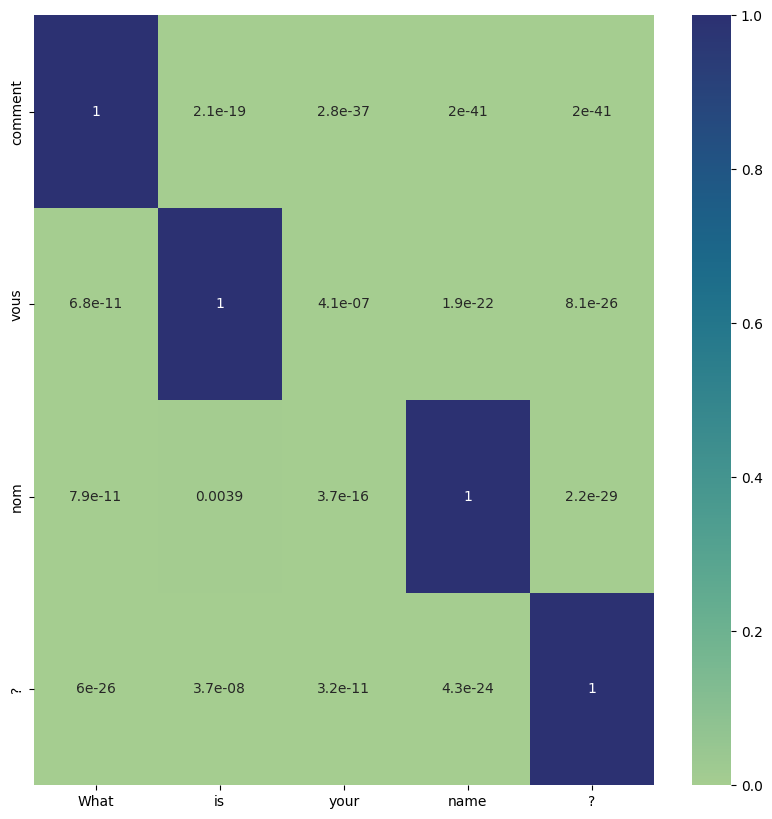

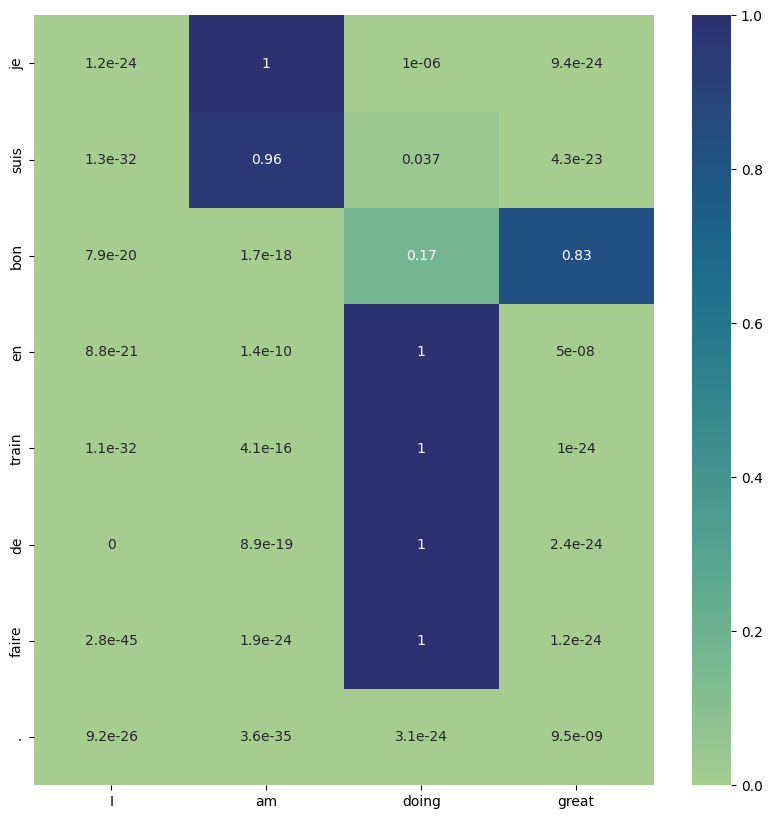

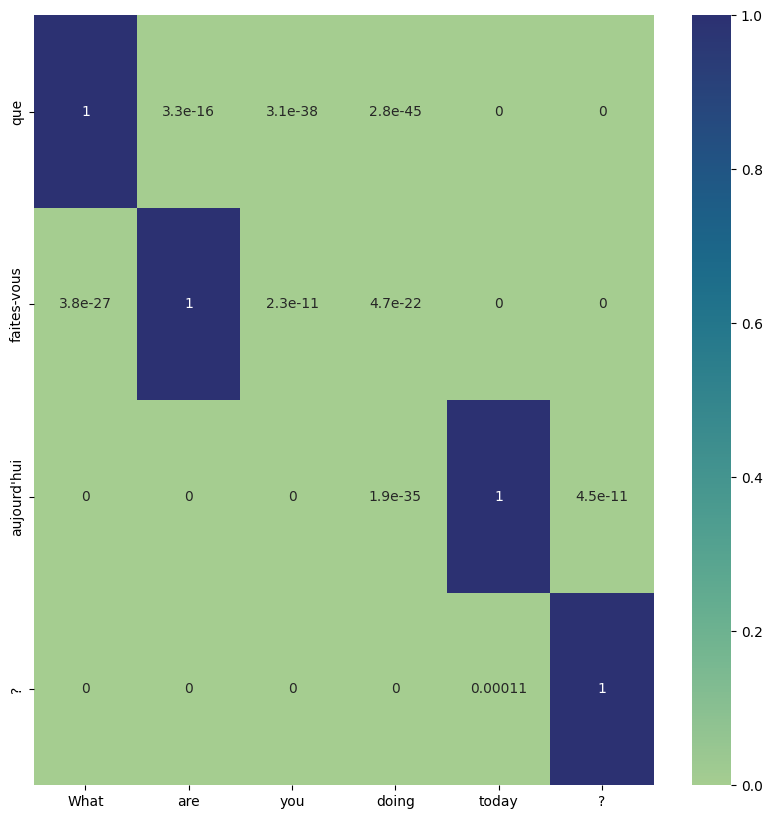

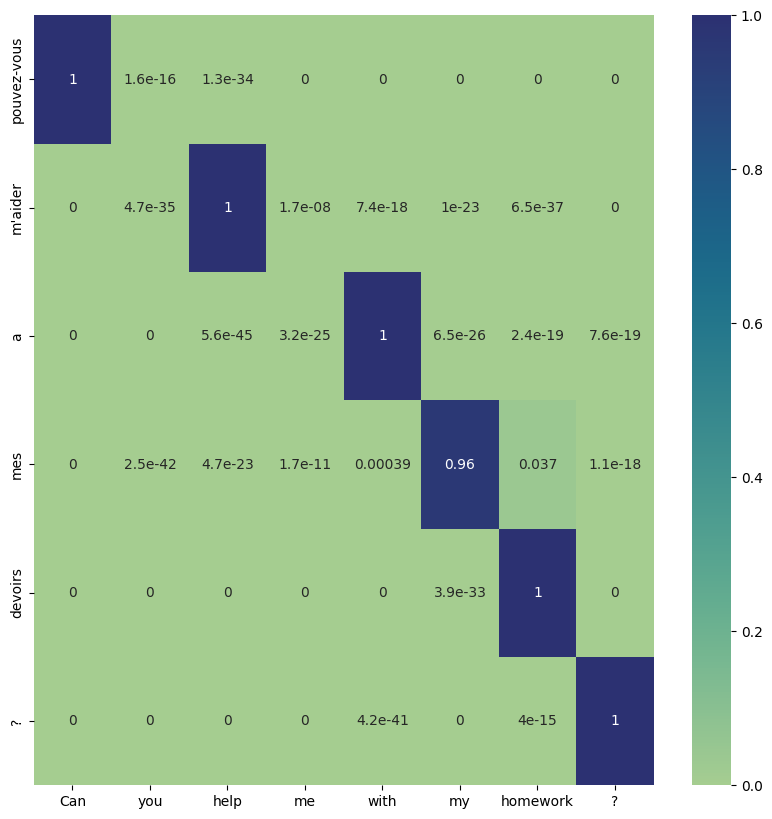

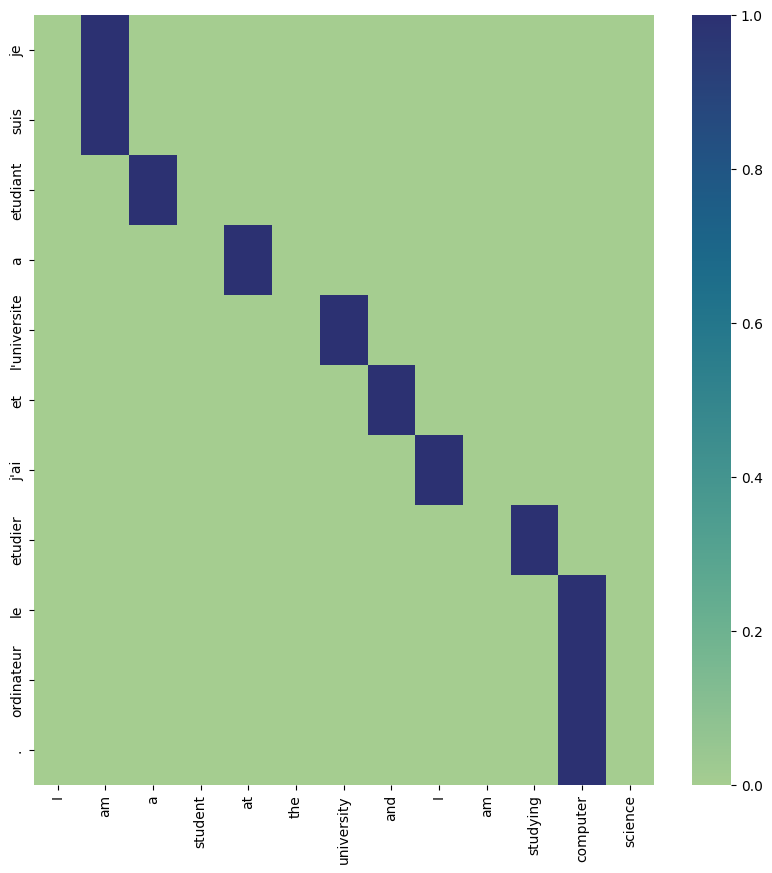

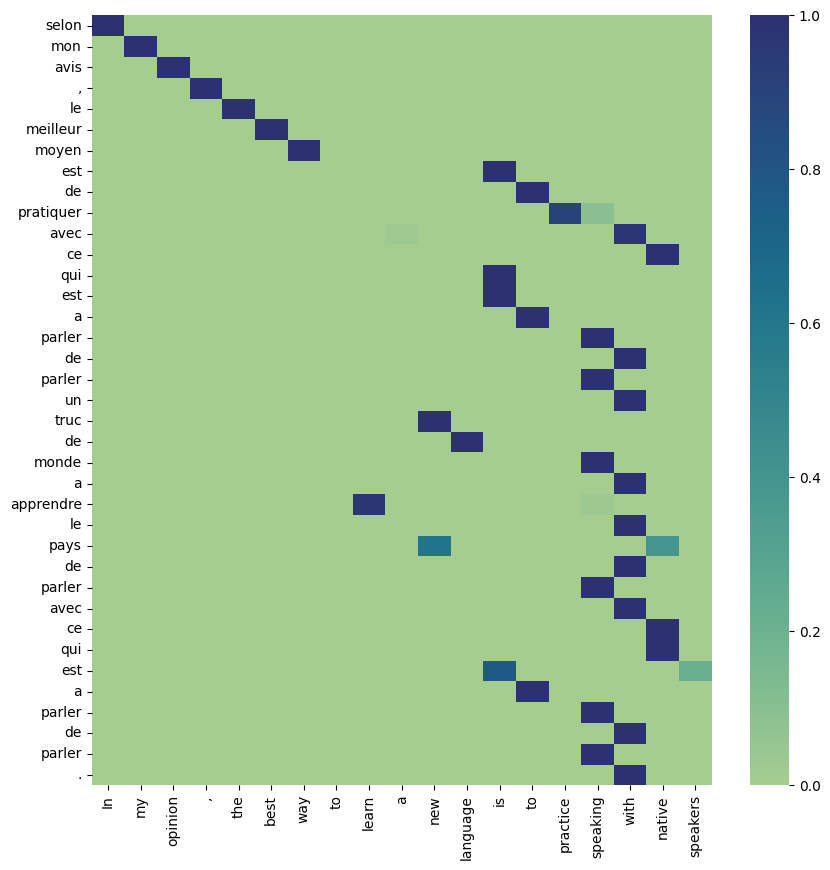

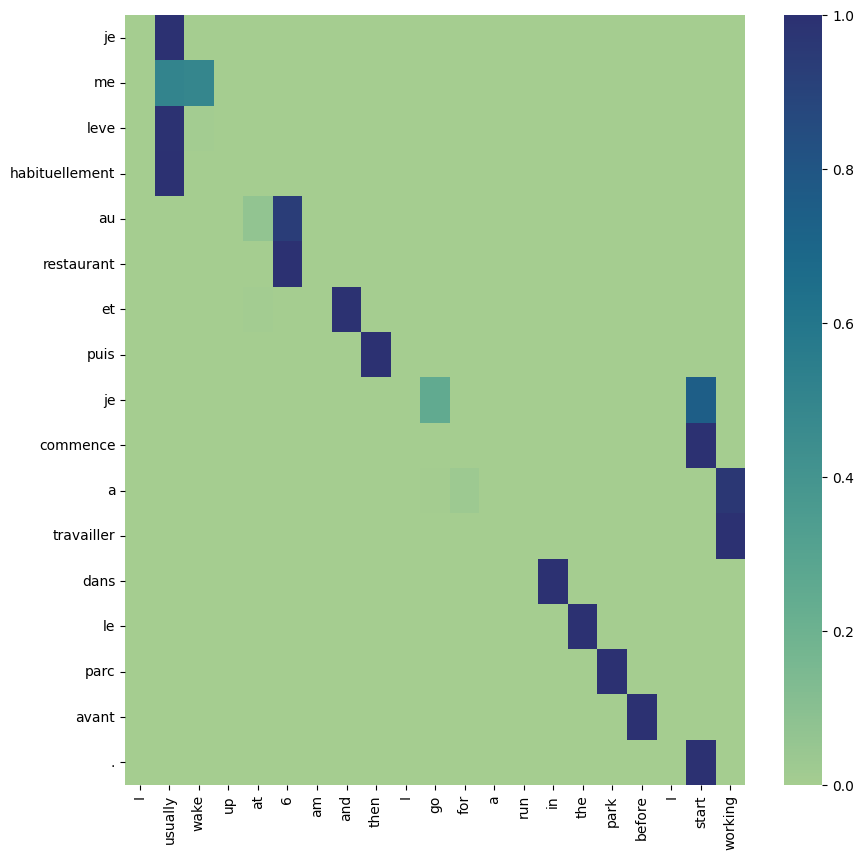

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_sentences = [
    'What is your name ?',
    'I am doing great',
    'What are you doing today ?',
    'Can you help me with my homework ?',
    'I am a student at the university and I am studying computer science',
    'In my opinion , the best way to learn a new language is to practice speaking with native speakers',
    'I usually wake up at 6 am and then I go for a run in the park before I start working',
]

for sentence in test_sentences:
    translated_sentence, attention = test_model(model, sentence, fr_inv_vocab, device)
    print(f'Src: {sentence}\nTgt: {translated_sentence}\n')
    
    translated_sentence, attention = test_model(model, sentence, fr_inv_vocab, device)
    # print(translated_sentenc)
    # print(attention)
    # print(attention.shape)

    # get the attention
    attention = attention.squeeze(1).cpu().numpy()
    
    attention = attention[:, 1:-1]
    plt.figure(figsize=(10, 10))
    annot = True
    if len(sentence.split()) > 8 or len(translated_sentence.split()) > 8:
        annot = False
    sns.heatmap(attention, xticklabels=sentence.split(), yticklabels=translated_sentence.split(), annot=annot, cmap='crest')

### 2. Seq2Seq Encoder-Decoder **without** Attention Model

NMTModel(
  (embeddings): WordEmbeddingForTranlationTask(
    (source): Embedding(14516, 512, padding_idx=0)
    (target): Embedding(28336, 512, padding_idx=0)
  )
  (encoder): LSTM(512, 512, bidirectional=True)
  (decoder): LSTMCell(1024, 512)
  (encoder_hidden_to_initial_decoder_hidden): Linear(in_features=1024, out_features=512, bias=False)
  (encoder_cell_to_initial_decoder_cell): Linear(in_features=1024, out_features=512, bias=False)
  (encoder_hidden_to_decoder_hidden_for_attention): Linear(in_features=1024, out_features=512, bias=False)
  (combined_output_and_hidden_to_hidden): Linear(in_features=512, out_features=512, bias=False)
  (target_vocab_projection): Linear(in_features=512, out_features=28336, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch 1, Average Train Loss: 41.97918433217738, Epoch 1, Average Val Loss: 28.387087060085342


Epoch 2, Average Train Loss: 25.504447367913276, Epoch 2, Average Val Loss: 22.944171647902788


Epoch 3, Average Train Loss: 21.231004439322337, Epoch 3, Average Val Loss: 20.49370920146303


Epoch 4, Average Train Loss: 17.237690348571423, Epoch 4, Average Val Loss: 18.937514068461024


Epoch 5, Average Train Loss: 14.466184929961862, Epoch 5, Average Val Loss: 18.337637086865463


Epoch 6, Average Train Loss: 12.261846533887086, Epoch 6, Average Val Loss: 17.913251269720313


Epoch 7, Average Train Loss: 10.524812365376505, Epoch 7, Average Val Loss: 18.05486142343465


Epoch 8, Average Train Loss: 9.091141787086855, Epoch 8, Average Val Loss: 18.399842413774234


Epoch 9, Average Train Loss: 7.949466339969755, Epoch 9, Average Val Loss: 18.710900702355406


Epoch 10, Average Train Loss: 7.0867133523402135, Epoch 10, Average Val Loss: 19.072679435157408


Epoch 11, Average Train Loss: 6.413775688286944, Epoch 11, Average Val Loss: 19.424050134212006


Epoch 12, Average Train Loss: 5.889222437340854, Epoch 12, Average Val Loss: 19.62151866756883


Epoch 13, Average Train Loss: 5.4312500271082005, Epoch 13, Average Val Loss: 19.996063569536677


Epoch 14, Average Train Loss: 5.130022629126508, Epoch 14, Average Val Loss: 20.459580644199836


Epoch 15, Average Train Loss: 4.820666358460327, Epoch 15, Average Val Loss: 20.634604991534456


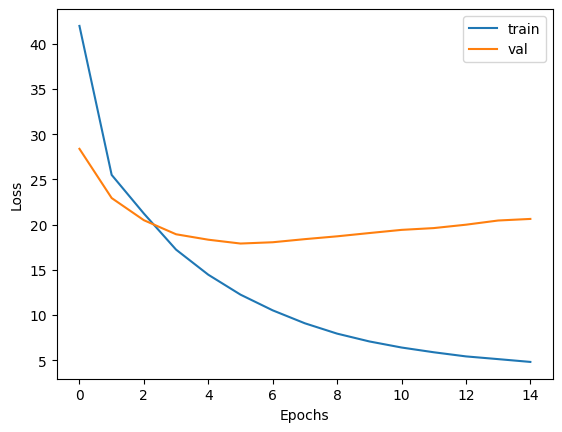

In [14]:
# create the model
model = NMTModel(en_vocab, fr_vocab, embedding_dim, hidden_dim, dropout, has_attention=False)
model.to(device)
model.train()

# check the model
print(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# train and validation
losses_all_epoch = train_val_NMTModel(model, train_loader, val_loader, optimizer, device, epochs)
plot_training_validation_loss(losses_all_epoch)

In [15]:
# test the model with the test_loader
score = test_model_bleu(model, test_loader, device)
print(f'bleu score with_out_attention: {score}')

bleu score with_out_attention: 0.21702699191107594


In [16]:
# save the model
model_path = "nmt_model_with_out_attention.pth"
torch.save(model.state_dict(), model_path)
# model_path = '/kaggle/input/nmt-model-1/nmt_model_1.pth'
# model.load_state_dict(torch.load(model_path))

In [17]:
test_sentences = [
    'What is your name?',
    'I am doing great',
    'What are you doing today?',
    'Can you help me with my homework?',
    'I am a student at the university and I am studying computer science',
    'In my opinion, the best way to learn a new language is to practice speaking with native speakers',
    'I usually wake up at 6 am and then I go for a run in the park before I start working',
]

for sentence in test_sentences:
    translated_sentence, attention = test_model(model, sentence, fr_inv_vocab, device)
    print(f'Src: {sentence}\nTgt: {translated_sentence}\n')

Src: What is your name?
Tgt: si nom ?

Src: I am doing great
Tgt: je ne suis pas un comme un .

Src: What are you doing today?
Tgt: ce que est-ce que tu manges ?

Src: Can you help me with my homework?
Tgt: si quelqu'un avec moi d'acquerir .

Src: I am a student at the university and I am studying computer science
Tgt: un jour , je ne suis pas sur de chouette et de meme .

Src: In my opinion, the best way to learn a new language is to practice speaking with native speakers
Tgt: si que ce qui sache , c'est quelqu'un de tres causer des conseils , que l'un de mes parents reviennent .

Src: I usually wake up at 6 am and then I go for a run in the park before I start working
Tgt: je me fiche que je vais m'allonger au tennis avant qu'ils ne soient pas bien sous une heure .

